In [1]:
using Rocket
using ReactiveMP
using GraphPPL
using BenchmarkTools
using Distributions
using MacroTools
using LinearAlgebra

In [2]:
@model [ default_factorisation = MeanField() ] function transition_model(n)
    
    A ~ MatrixDirichlet(ones(3, 3)) 
    B ~ MatrixDirichlet([ 10.0 1.0 1.0; 1.0 10.0 1.0; 1.0 1.0 10.0 ])
    
    s_0 ~ Categorical(fill(1.0 / 3.0, 3))
    
    s = randomvar(n)
    x = datavar(Vector{Float64}, n)
    
    s_prev = s_0
    
    for t in 1:n
        s[t] ~ Transition(s_prev, A) where { q = q(out, in)q(a) }
        x[t] ~ Transition(s[t], B)
        s_prev = s[t]
    end
    
    return s, x, A, B
end

transition_model (generic function with 1 method)

In [3]:
function inference(data, criterion)
    n = length(data)
    
    model, (s, x, A, B) = transition_model(n, options = (limit_stack_depth = 500, ))
    
    sbuffer = keep(Vector{Marginal})
    Abuffer = keep(Marginal)
    Bbuffer = keep(Marginal)
    fe      = ScoreActor(Float64)
    
    ssub  = subscribe!(getmarginals(s), sbuffer)
    Asub  = subscribe!(getmarginal(A), Abuffer)
    Bsub  = subscribe!(getmarginal(B), Bbuffer)
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)
    
    setmarginal!(A, vague(MatrixDirichlet, 3, 3))
    setmarginal!(B, vague(MatrixDirichlet, 3, 3))
    
    foreach(s) do svar
        setmarginal!(svar, vague(Categorical, 3))
    end
    
    update!(x, data)
    repeat!(model, criterion)
    
    unsubscribe!(ssub)
    unsubscribe!(Asub)
    unsubscribe!(Bsub)
    unsubscribe!(fesub)
    
    return map(getvalues, (sbuffer, Abuffer, Bbuffer, fe))
end

inference (generic function with 1 method)

In [4]:
using Random

function rand_vec(distribution::Categorical) 
    k = ncategories(distribution)
    s = zeros(k)
    s[ rand(distribution) ] = 1.0
    s
end

function generate_data(n_samples; seed = 124)
    Random.seed!(seed)
    
    # Transition probabilities (some transitions are impossible)
    A = [0.9 0.0 0.1; 0.1 0.9 0.0; 0.0 0.1 0.9] 
    # Observation noise
    B = [0.9 0.05 0.05; 0.05 0.9 0.05; 0.05 0.05 0.9] 
    # Initial state
    s_0 = [1.0, 0.0, 0.0] 
    # Generate some data
    s = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the states
    x = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the observations
    
    s_prev = s_0
    
    for t = 1:n_samples
        a = A * s_prev
        s[t] = rand_vec(Categorical(a ./ sum(a)))
        b = B * s[t]
        x[t] = rand_vec(Categorical(b ./ sum(b)))
        s_prev = s[t]
    end
    
    return x, s
end

generate_data (generic function with 1 method)

In [5]:
x_data, s_data = generate_data(100);

In [6]:
@time sbuffer, Abuffer, Bbuffer, fe = inference(x_data, 20);

 15.646979 seconds (36.65 M allocations: 2.120 GiB, 4.37% gc time, 99.65% compilation time)


In [7]:
@time sbuffer, Abuffer, Bbuffer, fe = inference(x_data, 20);

  0.039367 seconds (457.44 k allocations: 35.122 MiB)


In [8]:
@benchmark sbuffer, Abuffer, Bbuffer, fe = inference($x_data, 20)

BechmarkTools.Trial: 108 samples with 1 evaluations.
 Range (min … max):  36.869 ms … 64.785 ms  ┊ GC (min … max):  0.00% … 12.39%
 Time  (median):     46.000 ms              ┊ GC (median):    16.00%
 Time  (mean ± σ):   46.602 ms ±  5.197 ms  ┊ GC (mean ± σ):  12.92% ±  6.46%

                   ▄▃█ ▅ ▃   ▂                                 
  ▅▆▃▅▅▃▃▁▅▃▁▃▁▆▁▁▆███▅███▅▆▇█▅▅▁▇▁▃▁▁▁▃▁▅▅▁▁▃▃▁▃▃▁▁▃▁▁▁▁▁▁▁▅ ▃
  36.9 ms         Histogram: frequency by time        62.2 ms <

 Memory estimate: 35.12 MiB, allocs estimate: 457431.

In [9]:
mean(Abuffer[end])

3×3 Matrix{Float64}:
 0.892936   0.0830094  0.133809
 0.0858577  0.691162   0.0427901
 0.0212067  0.225829   0.823401

In [10]:
mean(Bbuffer[end])

3×3 Matrix{Float64}:
 0.908146   0.0422219  0.071816
 0.0695002  0.882211   0.0430346
 0.0223535  0.0755672  0.885149

In [11]:
using Plots

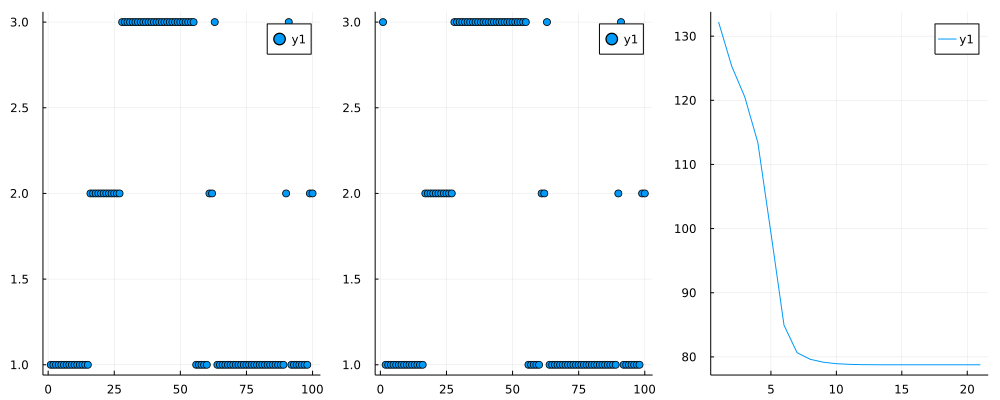

In [12]:
p1 = scatter(argmax.(s_data))
p2 = scatter(argmax.(ReactiveMP.probvec.(sbuffer[end])))
p3 = plot(fe)

plot(p1, p2, p3, size = (1000, 400), layout = @layout([ a b c ]))

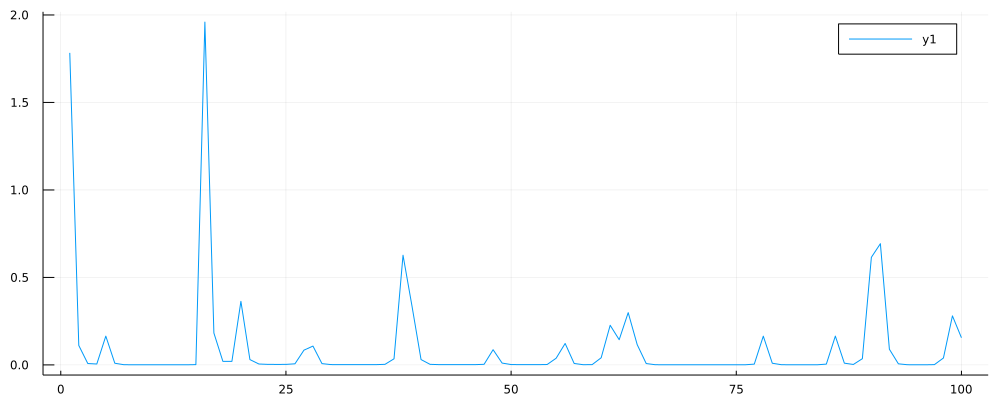

In [13]:
plot(sum.(map(a -> abs.(a), ReactiveMP.probvec.(sbuffer[end]) .- s_data)), size = (1000, 400))